# Transfer Learning with tensorflow part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns

In [1]:
# Are we using a GPU
!nvidia-smi

Sat Jun  4 19:15:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-06-04 19:15:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.198.128, 64.233.191.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.198.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   211MB/s    in 0.8s    

2022-06-04 19:15:39 (211 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder
import os

# Walk through 10 percent data directory
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

## Creating data loader (preparing the data)

We'll the ImageDataGenerator class to load in our images

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model train)

* Tensorboard
* ModelCheckpoint
* EarlyStopping

In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TF to create our own models.
Now we're going to use already build models from TF Hub : https://tfhub.dev/
After browsing we found this model efficientnet b0: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow_hub as hub
from tensorflow.keras import layers

In [11]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TF Hub URL and creates a Keras sequential model with it.
  
  Args:
    model_url (str): A TF Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of targets

  Returns:
   An Uncompiled Keras Sequential model with model_url as feature extractor
   layer and Dense output layer with num_classes output neurons
  """

  # Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,)) # Freeze the already learned patterns
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model


### Creating and Testing ResNet TF Hub Feature extraction model

In [22]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [23]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [24]:
# Fit the model
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnetV2_50")])

Saving TensorBoard log files to: tensorflow_hub/resnetV2_50/20220604-193642
Epoch 1/5
24/24 [==============================] - 20s 710ms/step - loss: 1.8880 - accuracy: 0.3907 - val_loss: 1.1253 - val_accuracy: 0.6612
Epoch 2/5
24/24 [==============================] - 16s 690ms/step - loss: 0.8561 - accuracy: 0.7560 - val_loss: 0.8391 - val_accuracy: 0.7376
Epoch 3/5
24/24 [==============================] - 16s 677ms/step - loss: 0.5993 - accuracy: 0.8427 - val_loss: 0.7352 - val_accuracy: 0.7628
Epoch 4/5
24/24 [==============================] - 16s 676ms/step - loss: 0.4604 - accuracy: 0.8880 - val_loss: 0.6980 - val_accuracy: 0.7728
Epoch 5/5
24/24 [==============================] - 17s 751ms/step - loss: 0.3736 - accuracy: 0.9213 - val_loss: 0.6747 - val_accuracy: 0.7768


In [16]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="Training loss")
  plt.plot(epochs, val_loss, label="Validation loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="Training accuracy")
  plt.plot(epochs, val_accuracy, label="Validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

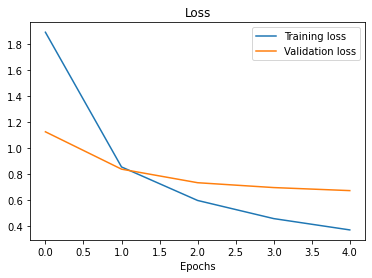

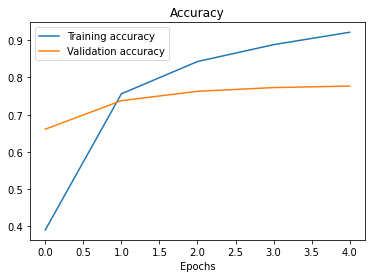

In [25]:
plot_loss_curves(history_resnet)

### Creating and Testing EfficientNet TF Hub Feature extraction model

In [28]:
# Create the model
efficientnet_model = create_model(model_url=efficientnet_url)

# Compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Train the model
history_efficientnet = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220604-200518
Epoch 1/5
24/24 [==============================] - 24s 687ms/step - loss: 1.9089 - accuracy: 0.3840 - val_loss: 1.3399 - val_accuracy: 0.7160
Epoch 2/5
24/24 [==============================] - 15s 649ms/step - loss: 1.0875 - accuracy: 0.7573 - val_loss: 0.8872 - val_accuracy: 0.8080
Epoch 3/5
24/24 [==============================] - 15s 648ms/step - loss: 0.7706 - accuracy: 0.8427 - val_loss: 0.7087 - val_accuracy: 0.8412
Epoch 4/5
24/24 [==============================] - 15s 645ms/step - loss: 0.6178 - accuracy: 0.8627 - val_loss: 0.6185 - val_accuracy: 0.8544
Epoch 5/5
24/24 [==============================] - 15s 648ms/step - loss: 0.5243 - accuracy: 0.8920 - val_loss: 0.5605 - val_accuracy: 0.8576


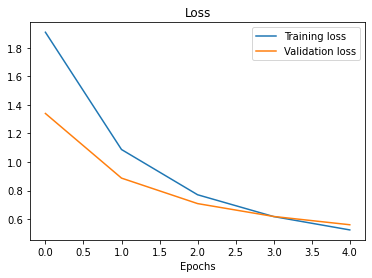

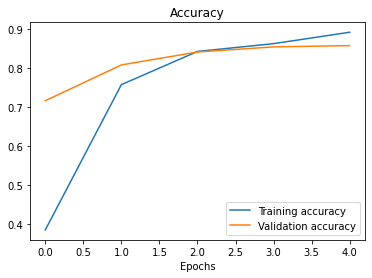

In [30]:
plot_loss_curves(history_efficientnet)

In [31]:
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Different types of transfer learning

* **As is** transfer learning - using an existing model with no changes (e.g using ImageNet model)
* **Feature extraction** transfer learning - use the prelearned patterns of an existing model and change the output layer
* **Fine-tuning** transfer learning - use the prelearned model and **fine-tune** many or all of the underlying layers (including new output layers)

## Comparing our models results using Tensorboard

In [33]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two TF hub feature extraction model architectures using 10% of the training data" \
  --one_shotyes
  


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=GYRj0FqJXDKpLYQuVmRLe0EyH87Ukh&prompt=consent&access_type=off

Our experiments : https://tensorboard.dev/experiment/wfj9mck8S9ibzZOtMfom5w/